## Single Track Demo

Process a single ATL03 granule using SlideRule's ATL06-SR algorithm and compare the results to the existing ATL06 data product.

### What is demonstrated

* The `icesat2.atl06` API is used to perform a SlideRule processing request of a single ATL03 granule
* The `icesat2.h5` API is used to read existing ATL06 datasets
* The `matplotlib` package is used to plot the elevation profile of all three tracks in the granule (with the first track overlaid with the expected profile)
* The `cartopy` package is used to produce different plots representing the geolocation of the gridded elevations produced by SlideRule.

### Points of interest

Most use cases for SlideRule use the higher level `icesat2.atl06p` API which works on a region of interest; but this notebook shows some of the capabilities of SlideRule for working on individual granules.

In [1]:
import sys

import pandas as pd
import numpy as np
import math

from sliderule import icesat2

In [2]:
# Configure Session #
icesat2.init("icesat2sliderule.org", True)
resource = "_20181019065445_03150111_003_01.h5"

In [3]:
#
# Distance between two coordinates
#
def geodist(lat1, lon1, lat2, lon2):

    lat1 = math.radians(lat1)
    lon1 = math.radians(lon1)
    lat2 = math.radians(lat2)
    lon2 = math.radians(lon2)

    dlon = lon2 - lon1
    dlat = lat2 - lat1

    dist = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    dist = 2.0 * math.atan2(math.sqrt(dist), math.sqrt(1.0 - dist))
    dist = 6373.0 * dist

    return dist

In [4]:
#
# ATL06 Read Request
#
def expread(resource, asset):

    # Read ATL06 Data
    segments    = icesat2.h5("/gt1r/land_ice_segments/segment_id",  resource, asset)
    heights     = icesat2.h5("/gt1r/land_ice_segments/h_li",        resource, asset)
    latitudes   = icesat2.h5("/gt1r/land_ice_segments/latitude",    resource, asset)
    longitudes  = icesat2.h5("/gt1r/land_ice_segments/longitude",   resource, asset)

    # Build Dataframe of SlideRule Responses    
    lat_origin = latitudes[0]
    lon_origin = longitudes[0]
    distances = [geodist(lat_origin, lon_origin, latitudes[i], longitudes[i]) for i in range(len(heights))]
    df = pd.DataFrame(data=list(zip(heights, distances, latitudes, longitudes)), index=segments, columns=["h_mean", "distance", "latitude", "longitude"])

    # Filter Dataframe
    df = df[df["h_mean"] < 25000.0]
    df = df[df["h_mean"] > -25000.0]
    df = df[df["distance"] < 4000.0]

    # Return DataFrame
    print("Retrieved {} points from ATL06, returning {} points".format(len(heights), len(df.values)))
    return df

In [5]:
#
# SlideRule Processing Request
#
def algoexec(resource):

    # Build ATL06 Request
    parms = {
        "cnf": 4,
        "ats": 20.0,
        "cnt": 10,
        "len": 40.0,
        "res": 20.0,
        "maxi": 1
    }

    # Request ATL06 Data
    rsps = icesat2.atl06(parms, resource, as_numpy=False)

    # Calculate Distances
    lat_origin = rsps["lat"][0]
    lon_origin = rsps["lon"][0]
    distances = [geodist(lat_origin, lon_origin, rsps["lat"][i], rsps["lon"][i]) for i in range(len(rsps["h_mean"]))]

    # Build Dataframe of SlideRule Responses
    df = pd.DataFrame(data=list(zip(rsps["h_mean"], distances, rsps["lat"], rsps["lon"], rsps["spot"])), index=rsps["segment_id"], columns=["h_mean", "distance", "latitude", "longitude", "spot"])

    # Return DataFrame
    print("Reference Ground Tracks: {} to {}".format(min(rsps["rgt"]), max(rsps["rgt"])))
    print("Cycle: {} to {}".format(min(rsps["cycle"]), max(rsps["cycle"])))
    print("Retrieved {} points from SlideRule".format(len(rsps["h_mean"])))
    return df

In [6]:
# Execute SlideRule Algorithm
act = algoexec("ATL03"+resource)

atl06 processing initiated on ATL03_20181019065445_03150111_003_01.h5 ...
... continuing to read ATL03_20181019065445_03150111_003_01.h5 (after 10 seconds)
processing of ATL03_20181019065445_03150111_003_01.h5 complete


Reference Ground Tracks: 315 to 315
Cycle: 1 to 1
Retrieved 626157 points from SlideRule


In [15]:
# Read ATL06 Expected Results
exp = expread("ATL06"+resource, "atl06-s3")

IndexError: list index out of range

In [9]:
# Build Standard (Expected) Dataset
standard1 = exp.sort_values(by=['distance'])

# Build Track (Actual) Datasets
track1 = act[act["spot"].isin([1, 2])].sort_values(by=['distance'])
track2 = act[act["spot"].isin([3, 4])].sort_values(by=['distance'])
track3 = act[act["spot"].isin([5, 6])].sort_values(by=['distance'])

## Matplotlib Plots

In [10]:
# Import MatPlotLib Package
import matplotlib.pyplot as plt

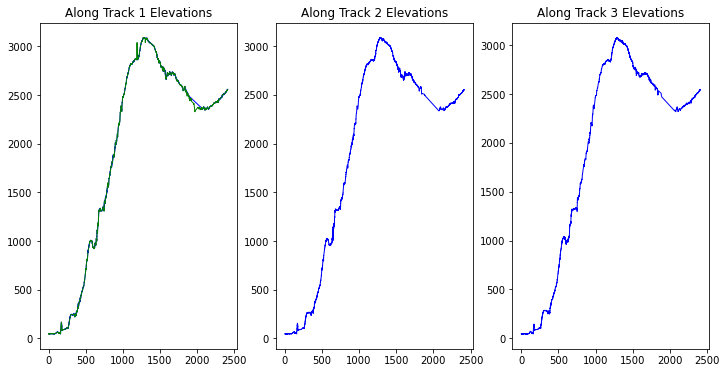

In [11]:
# Create Elevation Plot
fig = plt.figure(num=None, figsize=(12, 6))

# Plot Track 1 Elevations
ax1 = plt.subplot(131)
ax1.set_title("Along Track 1 Elevations")
ax1.plot(track1["distance"].values, track1["h_mean"].values, linewidth=1.0, color='b')
ax1.plot(standard1["distance"].values, standard1["h_mean"].values, linewidth=1.0, color='g')

# Plot Track 2 Elevations
ax2 = plt.subplot(132)
ax2.set_title("Along Track 2 Elevations")
ax2.plot(track2["distance"].values, track2["h_mean"].values, linewidth=1.0, color='b')

# Plot Track 3 Elevations
ax3 = plt.subplot(133)
ax3.set_title("Along Track 3 Elevations")
ax3.plot(track3["distance"].values, track3["h_mean"].values, linewidth=1.0, color='b')

# Show Plot
plt.show()

## Cartopy Plots

In [12]:
import cartopy
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

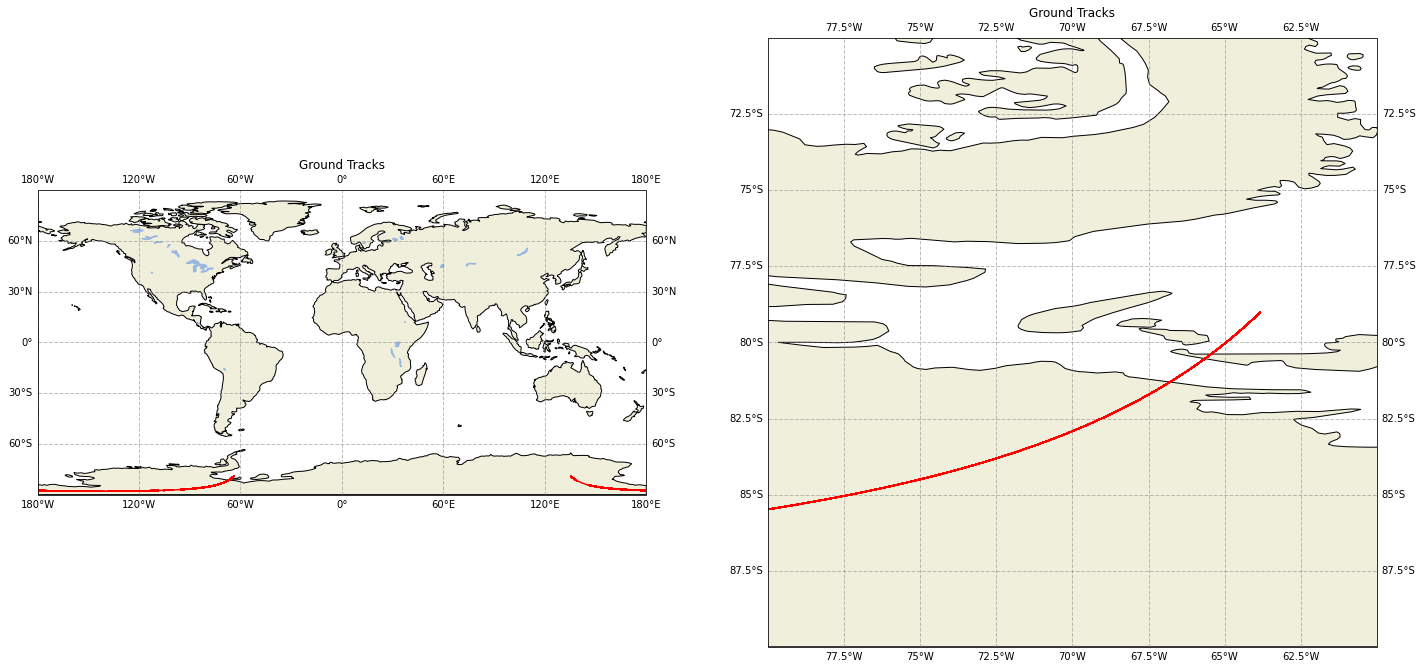

In [13]:
# Create PlateCarree Plot
fig = plt.figure(num=None, figsize=(24, 12))

################################
# add global plot
################################
ax1 = plt.subplot(121,projection=cartopy.crs.PlateCarree())
ax1.set_title("Ground Tracks")

# add coastlines with filled land and lakes
ax1.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax1.add_feature(cartopy.feature.LAKES)
ax1.set_extent((-180,180,-90,90),crs=cartopy.crs.PlateCarree())

# format grid lines
gl = ax1.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlocator = mticker.FixedLocator([-180, -120, -60, 0, 60, 120, 180])
gl.ylocator = mticker.FixedLocator([-90, -60, -30, 0, 30, 60, 90])

# plot ground tracks
ax1.plot(track1["longitude"], track1["latitude"], linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())

################################
# add zoomed plot
################################
ax2 = plt.subplot(122,projection=cartopy.crs.PlateCarree())
ax2.set_title("Ground Tracks")

# add coastlines with filled land and lakes
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax2.add_feature(cartopy.feature.LAKES)
ax2.set_extent((-80,-60,-90,-70),crs=cartopy.crs.PlateCarree())

# format grid lines
gl = ax2.gridlines(crs=cartopy.crs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# plot ground tracks
ax2.plot(track1["longitude"], track1["latitude"], linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())

# show plot
plt.show()

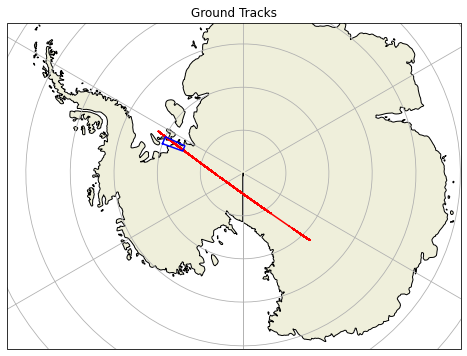

In [14]:
# Select Projection
#p = cartopy.crs.PlateCarree()
#p = cartopy.crs.LambertAzimuthalEqualArea()
p = cartopy.crs.SouthPolarStereo()

# Create SouthPolar Plot
fig = plt.figure(num=None, figsize=(12, 6))

ax1 = plt.axes(projection=p)
ax1.gridlines()

# Plot Ground Tracks
ax1.set_title("Ground Tracks")
ax1.plot(track1["longitude"].values,track1["latitude"].values,linewidth=1.5, color='r',zorder=2, transform=cartopy.crs.Geodetic())

# Plot Bounding Box
box_lon = [-70, -70, -65, -65, -70]
box_lat = [-80, -82.5, -82.5, -80, -80]
ax1.plot(box_lon, box_lat, linewidth=1.5, color='b', zorder=2, transform=cartopy.crs.Geodetic())

# add coastlines with filled land and lakes
ax1.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
ax1.add_feature(cartopy.feature.LAKES)

# add margin around plot for context
ax1.set_xmargin(1.0)
ax1.set_ymargin(1.0)

# show plot
plt.show()